In [1]:
import os
import h5py
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path

import utils_CNN as utils

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2024-06-04 15:41:13.520237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 15:41:13.596363: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Compute sample size before CNN cut

In [2]:
sample_dir = Path('../Sample/HVmodel/data/')

results_b = np.load(sample_dir/'selection_results_SB_4400_5800_b.npy', allow_pickle=True).item()
results_s = np.load(sample_dir/'selection_results_SB_4400_5800_s.npy', allow_pickle=True).item()

In [3]:
# Total cross section and number of events
xection, tot_event = utils.get_cross_section_and_nevent('../Sample/ppjj/Events/run_03')
print(xection, tot_event)

# cross section in signal region and sideband region
cross_section_SR = results_b['cutflow_number']['Signal region'] / results_b['cutflow_number']['Total'] * xection
cross_section_SB = results_b['cutflow_number']['Sideband region'] / results_b['cutflow_number']['Total'] * xection
cross_section_eta = results_b['cutflow_number']['jet eta cut'] / results_b['cutflow_number']['Total'] * xection
print(f'Background cross section, SR: {cross_section_SR:.2f} fb, SB: {cross_section_SB:.2f} fb')

# number of background events in signal region and sideband region
L = 139 * 1
n_SR_B = cross_section_SR * L
n_SB_B = cross_section_SB * L
n_eta_B = cross_section_eta * L

print(f'Background sample size: SR: {n_SR_B:.1f}, SB: {n_SB_B:.1f}')

sensitivity = 1
n_SR_S = sensitivity * np.sqrt(n_SR_B)
n_SB_S = n_SR_S * results_s['cutflow_number']['Sideband region'] / results_s['cutflow_number']['Signal region']
n_eta_S = n_SR_S * results_s['cutflow_number']['jet eta cut'] / results_s['cutflow_number']['Signal region']
print(f'Signal sample size: SR: {n_SR_S:.1f}, SB: {n_SB_S:.1f}')

print(f'Sample size after eta cut: B: {n_eta_B:.1f}, S: {n_eta_S:.1f}')

6837.392481 1000000
Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 137.6, SB: 33.5
Sample size after eta cut: B: 527689.2, S: 221.2


# Load testing datasets

In [4]:
# load mjj information from HDF5 file
h5_path = sample_dir / 'split_val/mix_sample_test-mjj.h5'
with h5py.File(h5_path, 'r') as f:
    mjj = f['EVENT/Mjj'][:]

# load jet image from npy file
res = 25
npy_path = sample_dir / f'split_val/{res}x{res}/mix_sample_test-mjj.h5'
X, y = utils.load_samples(npy_path)

mjj_b = mjj[y == 0]
mjj_s = mjj[y == 1]

# Plot $m_{jj}$ distribution before CNN cut

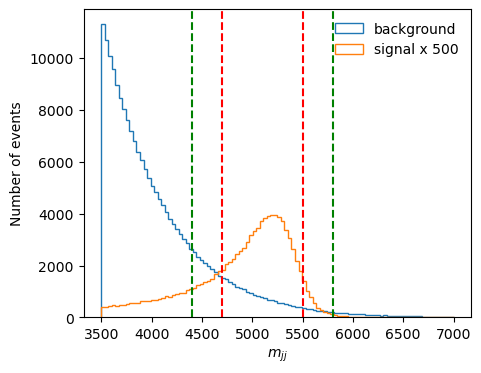

In [5]:
# plot mjj distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

n_bins = 100
hist_range = (3500, 7000)

weight_b = 1 / len(mjj_b) * np.ones_like(mjj_b) * n_eta_B
weight_s = 1 / len(mjj_s) * np.ones_like(mjj_s) * n_eta_S

ax.hist(mjj_b, bins=n_bins, range=hist_range, histtype='step', label='background', weights=weight_b)
ax.hist(mjj_s, bins=n_bins, range=hist_range, histtype='step', label='signal x 500', weights=weight_s * 500)


SRSB_region = [4400, 4700, 5500, 5800]
x_SR = SRSB_region[1], SRSB_region[2]
x_SB = SRSB_region[0], SRSB_region[3]
# 使用axvline函數繪製垂直線
ax.axvline(x=x_SR[0], color='r', linestyle='--')
ax.axvline(x=x_SR[1], color='r', linestyle='--')

ax.axvline(x=x_SB[0], color='g', linestyle='--')
ax.axvline(x=x_SB[1], color='g', linestyle='--')

ax.set_xlabel('$m_{jj}$')
ax.set_ylabel('Number of events')
ax.legend(frameon=False)
plt.show()

# Plot $m_{jj}$ distribution after CNN cut

In [6]:
def get_thresholds_of_model(model_name, X, y, passing_rates=[0.01]):
    # load the model
    save_model_name = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
    loaded_model = tf.keras.models.load_model(save_model_name)
    
    # get the predicted probability
    y_prob = loaded_model.predict(X)
    fpr, th = utils.get_fpr_thresholds(y == 1, y_prob)

    thresholds = []
    for passing_rate in passing_rates:
        threshold = utils.get_threshold_from_fpr(fpr, th, passing_rate)
        thresholds.append(threshold)

    return thresholds

In [7]:
def get_mjj_after_CNN_cut(mjj, event_scores, labels, thresholds):
    
    mjj_s_CNN = []
    mjj_b_CNN = []

    for threshold in thresholds:
        y_preds = (event_scores > threshold).reshape(-1)

        mjj_s_CNN.append(mjj[(labels == 1) & (y_preds)])
        mjj_b_CNN.append(mjj[(labels == 0) & (y_preds)])

    return mjj_s_CNN, mjj_b_CNN

In [8]:
def plot_mjj_distribution_CNN_cut(mjj_b, mjj_b_CNNs, n_before_cut, efficiencies, n_bins=50, hist_range=(3500, 7000), save_path=None):
    # plot mjj distribution

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    plt.subplots_adjust(wspace=0.3)

    titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]

    for i in range(3):
        # mjj_s_CNN = mjj_s_CNNs[i]
        mjj_b_CNN = mjj_b_CNNs[i]

        weight_b_CNN = 1 / mjj_b_CNN.shape[0] * np.ones_like(mjj_b_CNN) * mjj_b_CNN.shape[0] / mjj_b.shape[0] * n_before_cut
        # weight_s_CNN = 1 / mjj_s_CNN.shape[0] * np.ones_like(mjj_s_CNN) * mjj_s_CNN.shape[0] / mjj_s.shape[0] * n_eta_S

        weight_b = 1 / mjj_b.shape[0] * np.ones_like(mjj_b) * n_before_cut
        # weight_s = 1 / mjj_s.shape[0] * np.ones_like(mjj_s) * n_eta_S

        ax[i].hist(mjj_b, bins=n_bins, range=hist_range, histtype='step', label='$\eta$ cut, B', weights=weight_b)
        # ax[i].hist(mjj_s, bins=n_bins, range=hist_range, histtype='step', label='$\eta$ cut, S', weights=weight_s)

        bkg_eff = efficiencies[i]

        ax[i].hist(mjj_b_CNN, bins=n_bins, range=hist_range, histtype='step', label= f'CNN cut, B x {1 / bkg_eff:.0f}', weights=weight_b_CNN / bkg_eff)
        # ax[i].hist(mjj_s_CNN, bins=n_bins, range=hist_range, histtype='step', label= f'CNN cut, S x {1 / bkg_eff:.0f}', weights=weight_s_CNN / bkg_eff)


        SRSB_region = [4400, 4700, 5500, 5800]
        x_SR = SRSB_region[1], SRSB_region[2]
        x_SB = SRSB_region[0], SRSB_region[3]
        # 使用axvline函數繪製垂直線
        ax[i].axvline(x=x_SR[0], color='r', linestyle=':')
        ax[i].axvline(x=x_SR[1], color='r', linestyle=':')

        ax[i].axvline(x=x_SB[0], color='g', linestyle=':')
        ax[i].axvline(x=x_SB[1], color='g', linestyle=':')

        ax[i].set_xlabel('$m_{jj}$ [GeV]')
        ax[i].set_ylabel('Number of events')

        ax[i].set_title(titles[i])
        ax[i].legend(frameon=False)
    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')
    plt.show()

In [9]:
efficiencies = [0.1, 0.01, 0.001]
X_test_SB, y_test_SB = utils.load_samples('../Sample/HVmodel/data/split_val/25x25/mix_sample_test-SB.npy')

## Original

### Training

In [10]:
def get_mjj_from_h5(h5_dirs: list, nevents: tuple, seed=0):
    # h5_dirs: list of npy directories
    # nevents: tuple of (n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB)
    mjj_SR = []
    mjj_SB = []

    with h5py.File(os.path.join(h5_dirs[0], 'sig_in_SR.h5'), 'r') as f:
        size_sig_SR = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(os.path.join(h5_dirs[0], 'sig_in_SB.h5'), 'r') as f:
        size_sig_SB = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(os.path.join(h5_dirs[0], 'bkg_in_SR.h5'), 'r') as f:
        size_bkg_SR = f['EVENT/Mjj'][:].shape[0]
    with h5py.File(os.path.join(h5_dirs[0], 'bkg_in_SB.h5'), 'r') as f:
        size_bkg_SB = f['EVENT/Mjj'][:].shape[0]

    n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB = nevents

    np.random.seed(seed)
    idx_sig_SR = np.random.choice(size_sig_SR, n_sig_SR, replace=False)
    idx_sig_SB = np.random.choice(size_sig_SB, n_sig_SB, replace=False)
    idx_bkg_SR = np.random.choice(size_bkg_SR, n_bkg_SR, replace=False)
    idx_bkg_SB = np.random.choice(size_bkg_SB, n_bkg_SB, replace=False)

    print(f'Preparing mjj from {h5_dirs}')
    for h5_dir in h5_dirs:

        with h5py.File(os.path.join(h5_dir, 'sig_in_SR.h5'), 'r') as f:
            mjj_SR.extend(f['EVENT/Mjj'][:][idx_sig_SR])
        with h5py.File(os.path.join(h5_dir, 'bkg_in_SR.h5'), 'r') as f:
            mjj_SR.extend(f['EVENT/Mjj'][:][idx_bkg_SR])
        with h5py.File(os.path.join(h5_dir, 'sig_in_SB.h5'), 'r') as f:
            mjj_SB.extend(f['EVENT/Mjj'][:][idx_sig_SB])
        with h5py.File(os.path.join(h5_dir, 'bkg_in_SB.h5'), 'r') as f:
            mjj_SB.extend(f['EVENT/Mjj'][:][idx_bkg_SB])

    return np.array(mjj_SR), np.array(mjj_SB)


In [11]:

# determine the threshold from the training samples in SB region

config_file = 'config_files/origin_config_01.json'
# config_file = 'config_files/jet_aug_3_config_01.json'
# config_file = 'config_files/pt_jet_aug_3_config_01.json'

with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
train_h5_paths = ['../Sample/HVmodel/data/origin']
val_npy_paths = config['val_npy_paths']
seed = config['seed']
sensitivity = config['sensitivity']

true_label_path = config['true_label_path']
model_name = config['model_name']
sample_type = config['sample_type']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity)

train_nevents = int(n_SR_S * r_train), int(n_SB_S * r_train), int(n_SR_B * r_train), int(n_SB_B * r_train)
X_train_SR, y_train_SR, X_train_SB, y_train_SB  = utils.get_SR_SB_sample_from_npy(train_npy_paths, train_nevents, seed=seed)

mjj_SR, mjj_SB = get_mjj_from_h5(train_h5_paths, train_nevents, seed=seed)


Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']
Preparing mjj from ['../Sample/HVmodel/data/origin']


In [12]:

model_name = 'SB_0.0_25x25'
thresholds = get_thresholds_of_model(model_name, X_train_SB, y_train_SB, passing_rates=efficiencies)

# load the model
save_model_name = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(save_model_name)

X_train = np.concatenate([X_train_SR, X_train_SB], axis=0)
y_train = np.concatenate([y_train_SR, y_train_SB], axis=0)
mjj_train = np.concatenate([mjj_SR, mjj_SB], axis=0)

mjj_train_s = mjj_train[y_train == 1]
mjj_train_b = mjj_train[y_train == 0]

# get the predicted probability
y_prob = loaded_model.predict(X_train, batch_size=1024)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj_train, y_prob, y_train, thresholds)


2024-06-04 15:41:30.661966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 15:41:31.280232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6
2024-06-04 15:41:33.606542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


 34/506 [=>............................] - ETA: 2s

2024-06-04 15:41:35.090593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


31/31 [==============================] - 1s 10ms/step


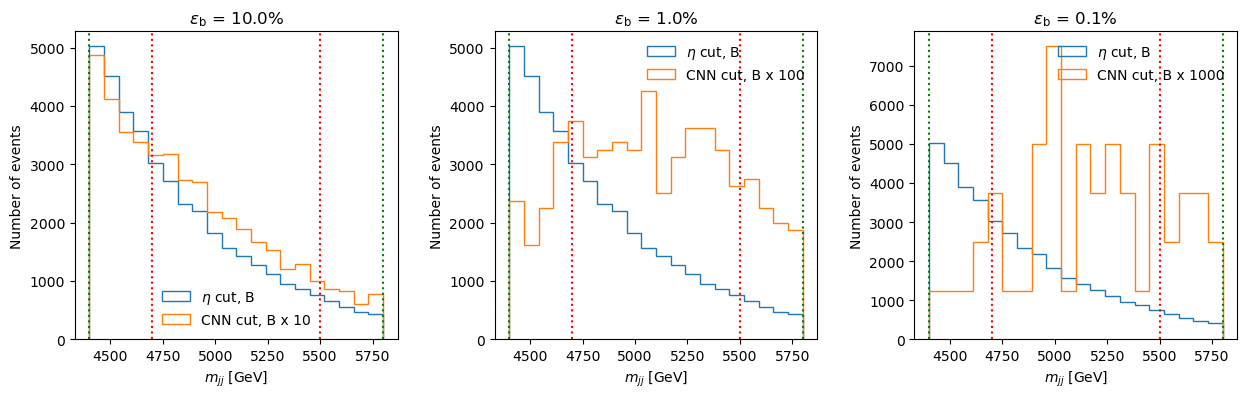

In [13]:
plot_mjj_distribution_CNN_cut(mjj_train,
                            mjj_b_CNNs,
                            n_before_cut=n_SR_B + n_SB_B,
                            efficiencies=efficiencies,
                            n_bins=20,
                            hist_range=(4400, 5800),
                            save_path=None
                            )

### Testing

In [14]:
# determine the threshold from the sideband region
model_name = 'SB_0.0_25x25'
thresholds = get_thresholds_of_model(model_name, X_test_SB, y_test_SB, passing_rates=efficiencies)

625/625 [==============================] - 3s 5ms/step


In [15]:
# load the model
save_model_name = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(save_model_name)

# get the predicted probability
y_prob = loaded_model.predict(X, batch_size=1024)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj, y_prob, y, thresholds)

2340/2340 [==============================] - 16s 7ms/step


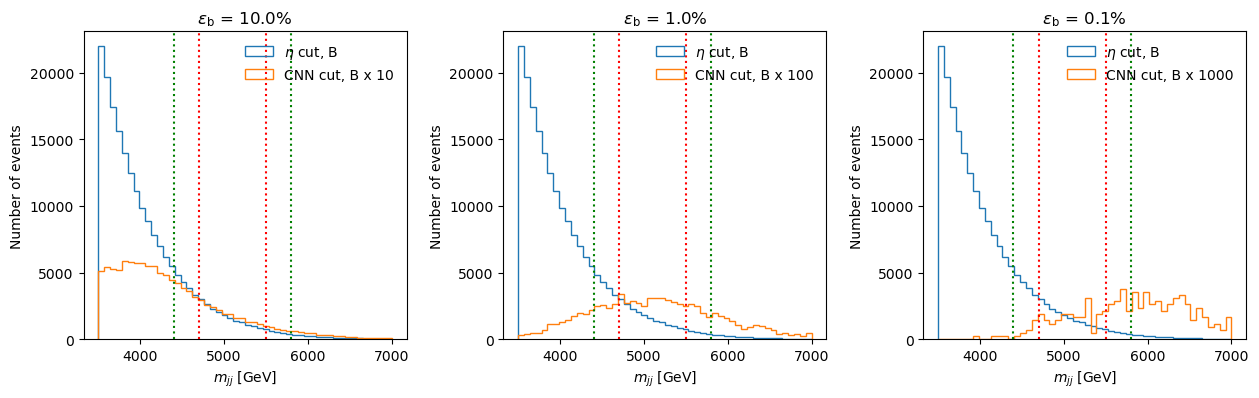

In [16]:
save_path = '../figures/mjj_distribution_before_after_CNN_cut_origin_SB_0.pdf'
plot_mjj_distribution_CNN_cut(mjj_b,
                              mjj_b_CNNs,
                              n_eta_B,
                              efficiencies,
                              save_path=save_path)

## +3 Jet rotation

In [17]:
# determine the threshold from the sideband region
model_name = 'SB_0.0_jet_aug_3_25x25'
thresholds = get_thresholds_of_model(model_name, X_test_SB, y_test_SB, passing_rates=efficiencies)

625/625 [==============================] - 3s 5ms/step


In [18]:
# load the model
save_model_name = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(save_model_name)

# get the predicted probability
y_prob = loaded_model.predict(X, batch_size=1024)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj, y_prob, y, thresholds)

2340/2340 [==============================] - 17s 7ms/step


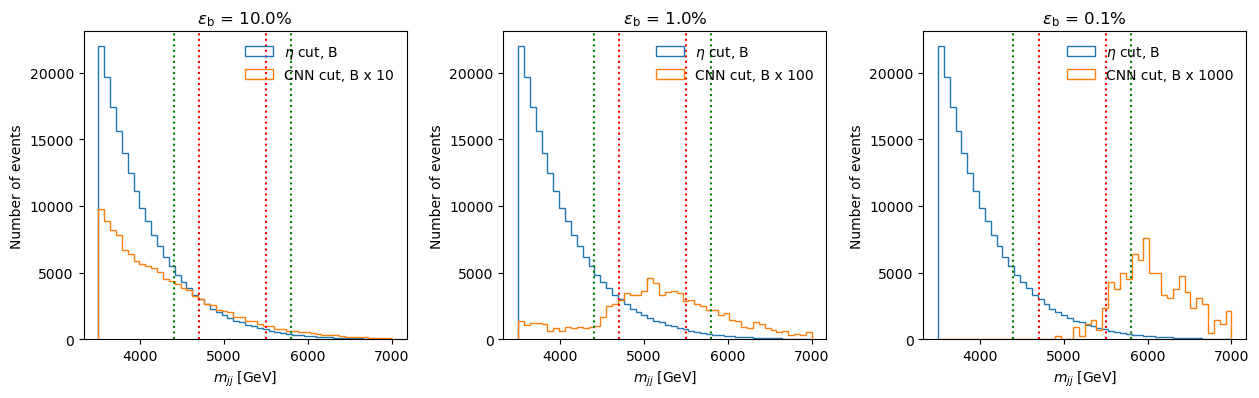

In [19]:
save_path = '../figures/mjj_distribution_before_after_CNN_cut_jet_aug_3_SB_0.pdf'
plot_mjj_distribution_CNN_cut(mjj_b,
                              mjj_b_CNNs,
                              n_eta_B,
                              efficiencies,
                              save_path=save_path)

## +3 $p_\text{T}$ smearing + Jet rotation

In [20]:
# determine the threshold from the sideband region
model_name = 'SB_0.0_pt_jet_aug_3_25x25'
thresholds = get_thresholds_of_model(model_name, X_test_SB, y_test_SB, passing_rates=efficiencies)

625/625 [==============================] - 3s 5ms/step


In [22]:
# load the model
save_model_name = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(save_model_name)

# get the predicted probability
y_prob = loaded_model.predict(X, batch_size=1024)

mjj_s_CNNs, mjj_b_CNNs = get_mjj_after_CNN_cut(mjj, y_prob, y, thresholds)

2340/2340 [==============================] - 17s 7ms/step


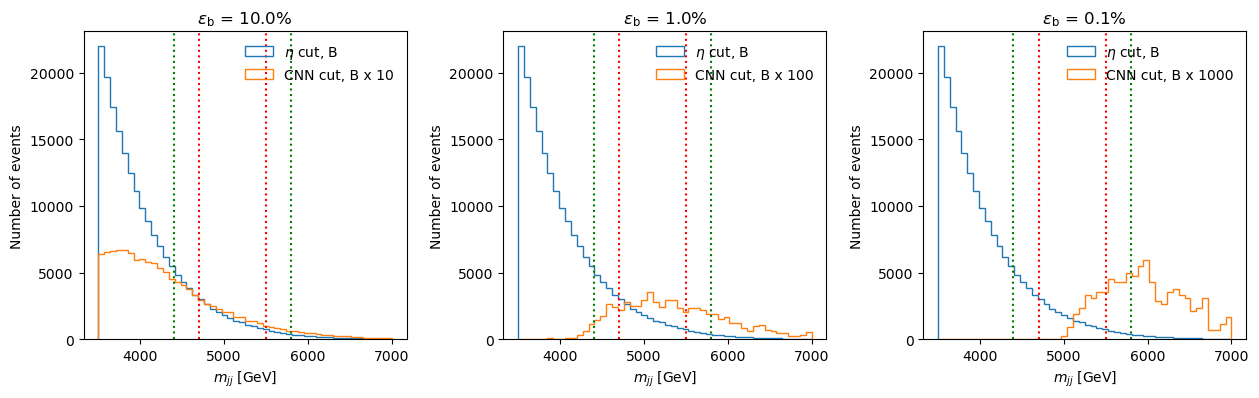

In [23]:
save_path = '../figures/mjj_distribution_before_after_CNN_cut_pt_jet_aug_3_SB_0.pdf'
plot_mjj_distribution_CNN_cut(mjj_b,
                              mjj_b_CNNs,
                              n_eta_B,
                              efficiencies,
                              save_path=save_path)